Skewness for each numerical column:
price        1.212239
area         1.321188
bedrooms     0.495684
bathrooms    1.589264
stories      1.082088
parking      0.842062
dtype: float64


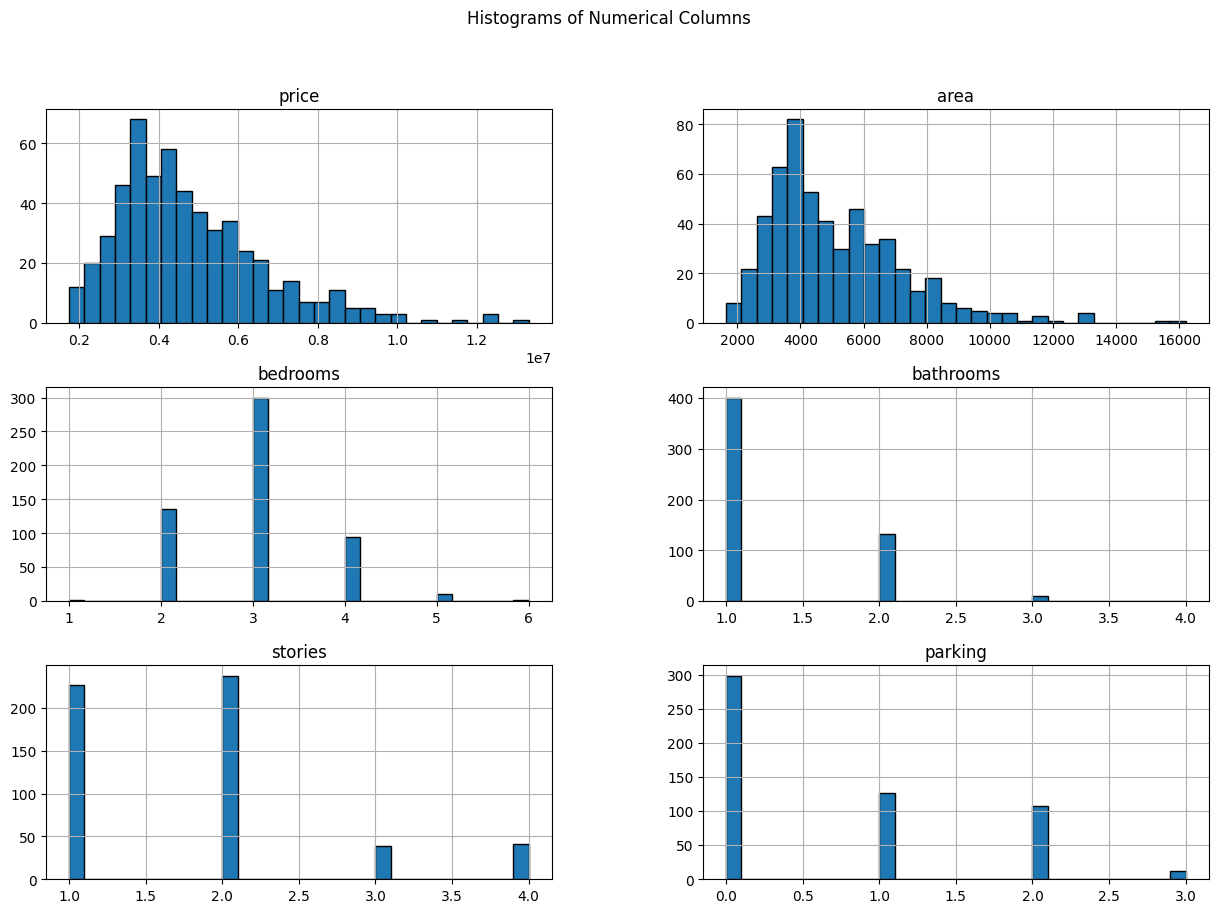

In [18]:
import pandas as pd

# Load dataset
file_path = '/content/Housing.csv'
df = pd.read_csv(file_path)

# Step 1: Select numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Calculate skewness for numerical columns
skewness = df[numerical_columns].skew()

# Step 3: Display skewness values
print("Skewness for each numerical column:")
print(skewness)

# Step 4: Visualize skewness using histograms
import matplotlib.pyplot as plt

# Plot histograms for numerical columns
df[numerical_columns].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns")
plt.show()


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load dataset
file_path = '/content/Housing.csv'  # Update path as needed
df = pd.read_csv(file_path)

In [21]:
# Applying log transformation to reduce skewness
df['log_price'] = np.log(df['price'] + 1)  # Add 1 to avoid log(0)
df['log_area'] = np.log(df['area'] + 1)
df['log_bathrooms'] = np.log(df['bathrooms'] + 1)
df['log_stories'] = np.log(df['stories'] + 1)

# Step 1: Outlier Removal Using IQR Method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Identify the numerical columns for outlier removal
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Remove outliers
df_cleaned = remove_outliers(df, numerical_columns)

# Step 2: Data Preparation
# Identifying categorical columns for one-hot encoding
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

# Apply one-hot encoding
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)

# Define features and target
X = df_encoded.drop(columns=['price'])  # Replace 'price' with the actual target column
y = df_encoded['price']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [23]:
# Step 3: Regression Models

# Function to evaluate models
def evaluate_model(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return r2, rmse, mape

# 1. Ridge Regression (Tuned)
param_distributions_ridge = {'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_pipeline = make_pipeline(StandardScaler(), Ridge())
random_search_ridge = RandomizedSearchCV(estimator=ridge_pipeline, param_distributions=param_distributions_ridge,
                                         n_iter=6, cv=5, random_state=42, n_jobs=-1, scoring='r2')
random_search_ridge.fit(X_train, y_train)
best_ridge_model = random_search_ridge.best_estimator_
y_pred_ridge_tuned = best_ridge_model.predict(X_test)

In [25]:
# 2. Lasso Regression (Tuned)
param_distributions_lasso = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_pipeline = make_pipeline(StandardScaler(), Lasso())
random_search_lasso = RandomizedSearchCV(estimator=lasso_pipeline, param_distributions=param_distributions_lasso,
                                         n_iter=6, cv=5, random_state=42, n_jobs=-1, scoring='r2')
random_search_lasso.fit(X_train, y_train)
best_lasso_model = random_search_lasso.best_estimator_
y_pred_lasso_tuned = best_lasso_model.predict(X_test)


In [27]:
# 3. Elastic Net Regression (Tuned)
param_distributions_elastic = {'elasticnet__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                               'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elastic_pipeline = make_pipeline(StandardScaler(), ElasticNet())
random_search_elastic = RandomizedSearchCV(estimator=elastic_pipeline, param_distributions=param_distributions_elastic,
                                           n_iter=15, cv=5, random_state=42, n_jobs=-1, scoring='r2')
random_search_elastic.fit(X_train, y_train)
best_elastic_model = random_search_elastic.best_estimator_
y_pred_elastic_tuned = best_elastic_model.predict(X_test)

In [28]:
# 4. Gradient Boosting (Tuned)
param_distributions_gbr = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}
gbr_model = GradientBoostingRegressor(random_state=42)
random_search_gbr = RandomizedSearchCV(estimator=gbr_model, param_distributions=param_distributions_gbr,
                                       n_iter=15, cv=5, random_state=42, n_jobs=-1, scoring='r2')
random_search_gbr.fit(X_train, y_train)
best_gbr_model = random_search_gbr.best_estimator_
y_pred_gbr = best_gbr_model.predict(X_test)

In [29]:
# Step 4: Model Evaluation

# Evaluate Ridge
ridge_r2_tuned, ridge_rmse_tuned, ridge_mape_tuned = evaluate_model(y_test, y_pred_ridge_tuned)

# Evaluate Lasso
lasso_r2_tuned, lasso_rmse_tuned, lasso_mape_tuned = evaluate_model(y_test, y_pred_lasso_tuned)

# Evaluate Elastic Net
elastic_r2_tuned, elastic_rmse_tuned, elastic_mape_tuned = evaluate_model(y_test, y_pred_elastic_tuned)

# Evaluate Gradient Boosting
gbr_r2_tuned, gbr_rmse_tuned, gbr_mape_tuned = evaluate_model(y_test, y_pred_gbr)

# Step 5: Model Comparison
model_comparison_tuned = pd.DataFrame({
    'Model': ['Ridge (Tuned)', 'Lasso (Tuned)', 'Elastic Net (Tuned)', 'Gradient Boosting (Tuned)'],
    'R2 Score': [ridge_r2_tuned, lasso_r2_tuned, elastic_r2_tuned, gbr_r2_tuned],
    'RMSE': [ridge_rmse_tuned, lasso_rmse_tuned, elastic_rmse_tuned, gbr_rmse_tuned],
    'MAPE': [ridge_mape_tuned, lasso_mape_tuned, elastic_mape_tuned, gbr_mape_tuned]
})

print(model_comparison_tuned)

                       Model  R2 Score           RMSE      MAPE
0              Ridge (Tuned)  0.957884  229669.404327  0.049385
1              Lasso (Tuned)  0.957343  231142.350496  0.049553
2        Elastic Net (Tuned)  0.957777  229962.345320  0.049434
3  Gradient Boosting (Tuned)  0.997476   56227.954147  0.002829
